## Simulation for testing VarEM vs CausalVarEM


In [2]:
from models.ICA_EM import *
from models.source_estimator import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [106]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [4]:
n = 10000
J = 6
I = J-1

In [123]:
# compare VarEM with CausalVarEM

treatmet_true = []
treatment_var_perm= []
treatment_causal_perm = []
score_var = []
score_causal = []
treatment_var_first_column = []
treatment_causal_first_column = []
mse_var = []
mse_causal = []
likelihood_score_var = []
likelihood_score_causal = []

data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)} ,noise_dict={"loc" : 0, "scale" : 1})

for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    estimator = VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator.A)    
    score_var.append(score)
    treatment_var_perm.append(norm_funtion(estimator.A[:, best_perm])[1])
    treatment_var_first_column.append(norm_funtion(estimator.A)[1])
    mse_var.append(mean_squared_error(data.signals, estimator.Signals[:, best_perm]))
    likelihood_score_var.append(likelihood_score(data.signals, estimator.Signals[:, best_perm]))


    estimator_Causal = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator_Causal.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator_Causal.A)    
    score_causal.append(score)
    treatmet_true.append(data.treatment_effect)
    treatment_causal_perm.append(norm_funtion(estimator_Causal.A[:,best_perm])[1])
    treatment_causal_first_column.append(norm_funtion(estimator_Causal.A)[1])
    mse_causal.append(mean_squared_error(data.signals, estimator_Causal.Signals[:, best_perm]))
    likelihood_score_causal.append(likelihood_score(data.signals, estimator_Causal.Signals[:, best_perm]))


100%|██████████| 100/100 [3:07:41<00:00, 112.61s/it] 


In [124]:
# save results
results = pd.DataFrame({"treatment_true" : treatmet_true, 
                        "treatment_var_perm" : treatment_var_perm, 
                        "treatment_var_first_column" : treatment_var_first_column, 
                        "treatment_causal_perm" : treatment_causal_perm,
                          "treatment_causal_first_column" : treatment_causal_first_column,
                            "score_var" : score_var,
                              "score_causal" : score_causal,
                                "mse_var" : mse_var,
                                  "mse_causal" : mse_causal,
                                    "likelihood_score_var" : likelihood_score_var,
                                      "likelihood_score_causal" : likelihood_score_causal})
results.to_csv("results_var_vs_causal.csv", index = False)

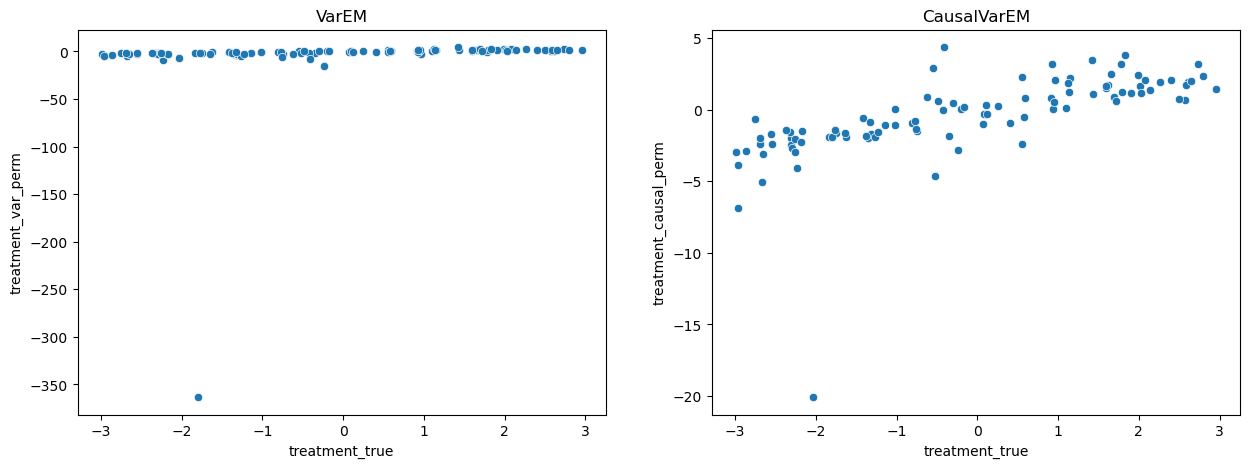

1312.5728992046154
4.8173748895133865


In [16]:
from sklearn.metrics import mean_squared_error
results = pd.read_csv("results_var_vs_causal.csv")
fig, ax = plt.subplots(1,2,figsize = (15,5)) 
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_perm, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true, results.treatment_var_perm))
print(mean_squared_error(results.treatment_true, results.treatment_causal_perm))

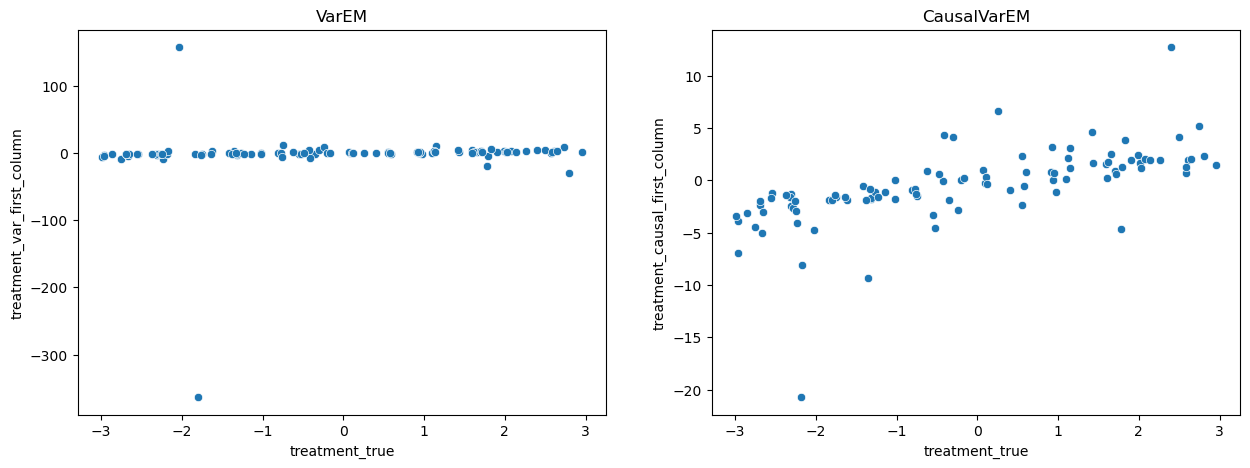

1583.2399350526302
8.243736540791087


In [22]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_first_column, ax = ax[0])
ax[0].title.set_text('VarEM')
#ax[0].set_ylim(-3,3)
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
#ax[1].set_ylim(-3,3)
plt.show()  
print(mean_squared_error(results.treatment_true, results.treatment_var_first_column))
print(mean_squared_error(results.treatment_true, results.treatment_causal_first_column))


In [127]:
ind_varEM = np.argmax(results.treatment_var_first_column)
ind_causal = np.argmin(results.treatment_causal_first_column)

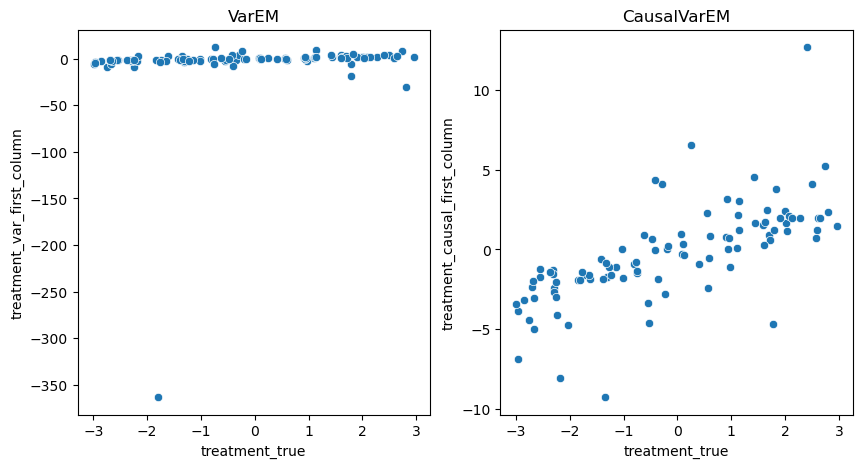

1343.8963660405402
4.860460314116148


In [128]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.scatterplot(x=results.treatment_true.drop(ind_varEM), y=results.treatment_var_first_column.drop(ind_varEM), ax=ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x =results.treatment_true.drop(ind_causal), y = results.treatment_causal_first_column.drop(ind_causal), ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()
print(mean_squared_error(results.treatment_true.drop(ind_varEM), results.treatment_var_first_column.drop(ind_varEM)))
print(mean_squared_error(results.treatment_true.drop(ind_causal), results.treatment_causal_first_column.drop(ind_causal)))

In [29]:
print(np.mean(results.mse_var))
print(np.mean(results.mse_causal))
print(np.mean(results.likelihood_score_var))
print(np.mean(results.likelihood_score_causal))
print(np.mean(results.score_var))
print(np.mean(results.score_causal))


1.2571295245855183
1.2413795165775732
-13134.026975774304
-13120.487584778879
0.38484977817282023
0.32856521560861296


In [23]:
# plot signals righltly ordered
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 0})
data.generate_data(n=n, J=J, I=I, random_state=2)
VarEM_est= VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
VarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})
CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= None, tol=1e-4, max_iter=200, random_seed=1, mode="each")
CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})



Initializing A with true A + noise


Diff: 0.0019: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 78578.72it/s]


Initializing A randomly


Diff: 0.0746: 100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 91716.26it/s]


0.621812081399002
0.03548394845917706


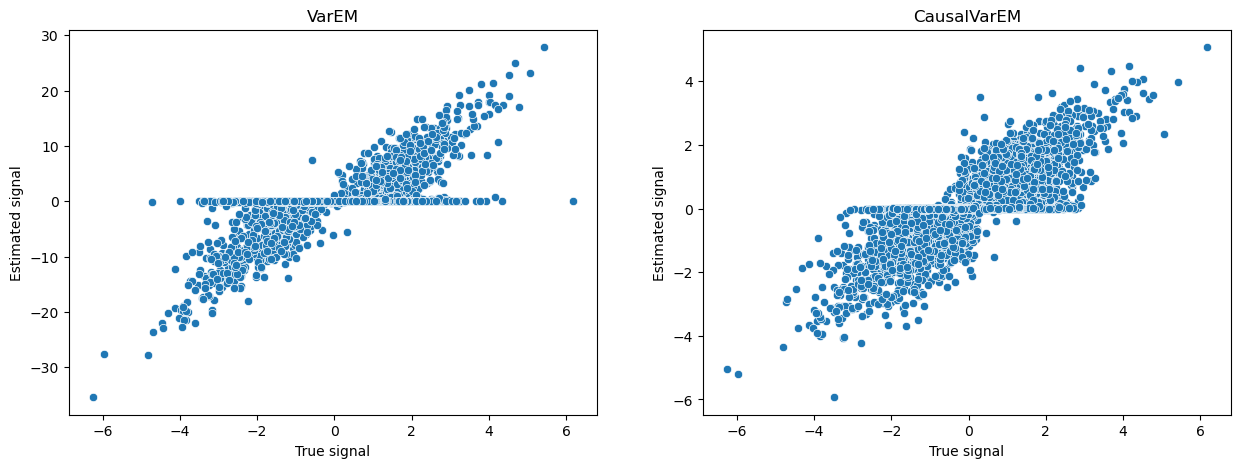

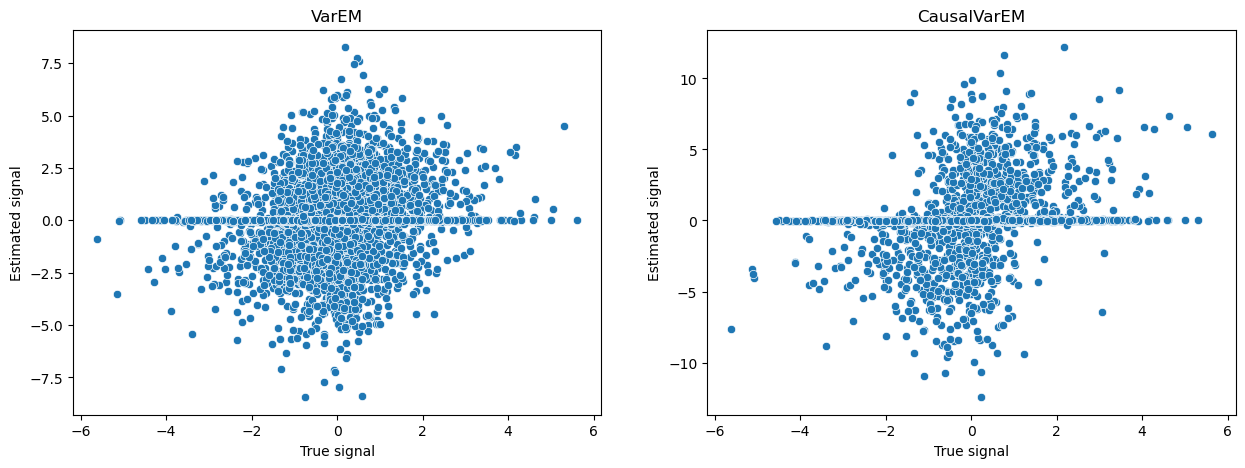

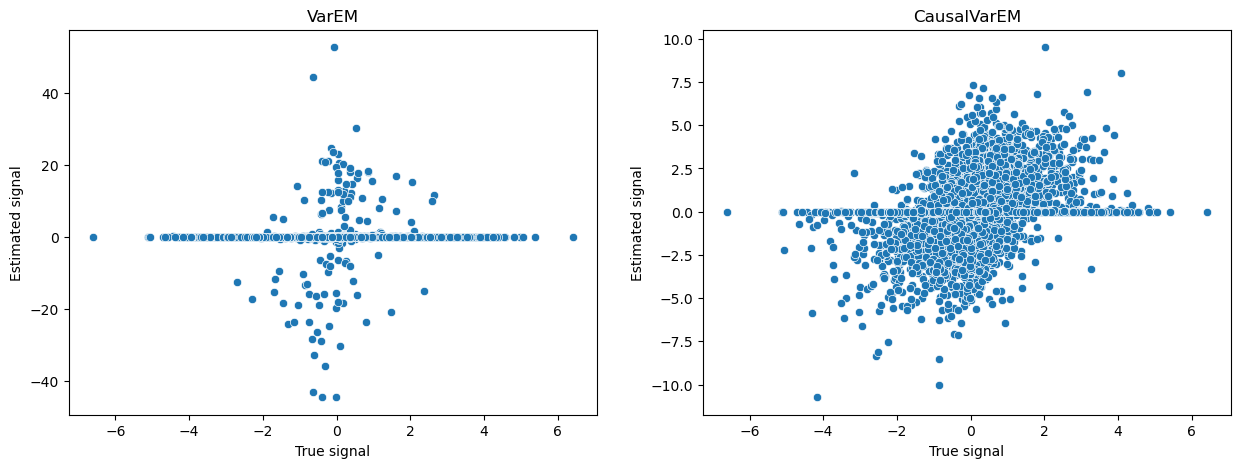

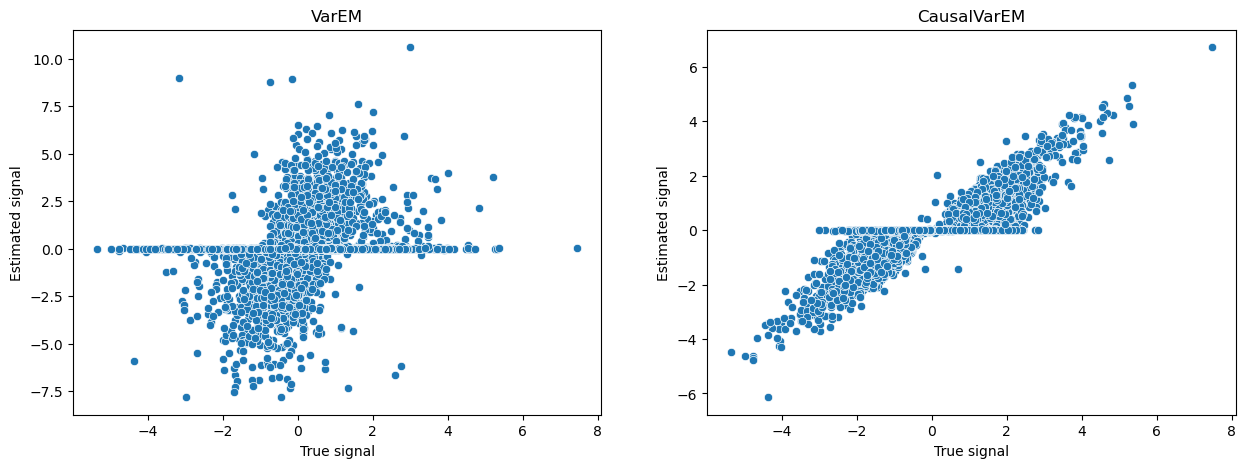

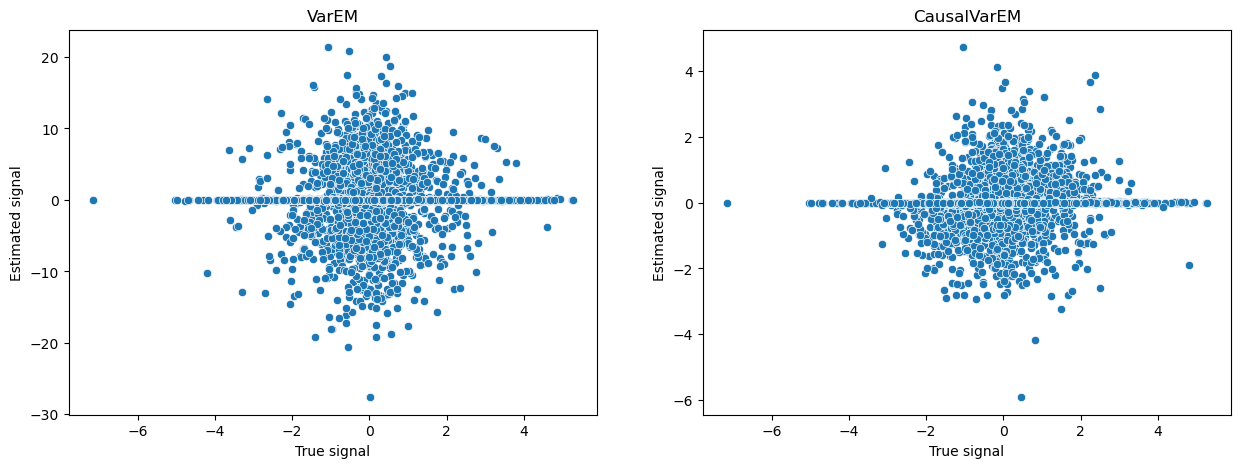

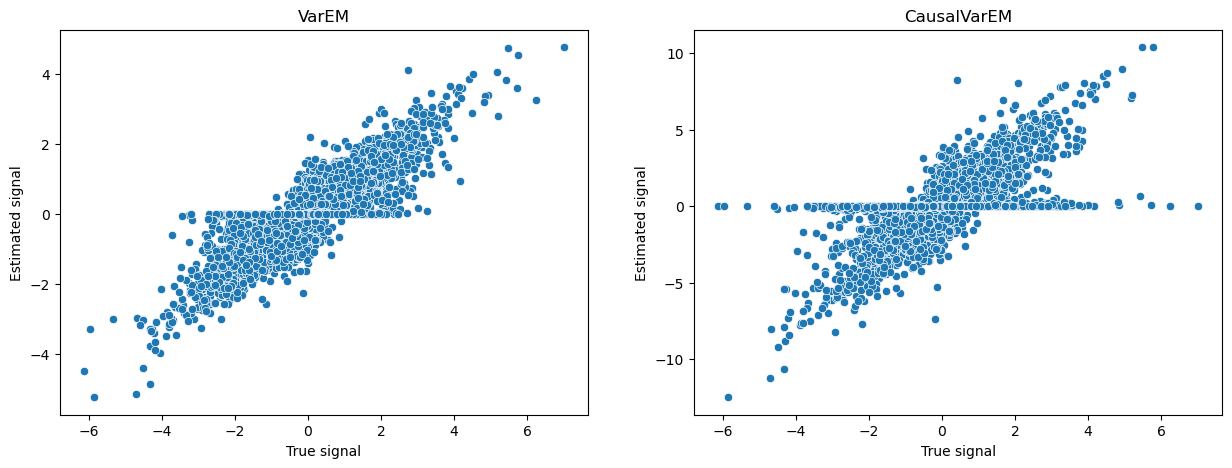

In [24]:
best_perm_var, score = f_score(data.mixing_matrix_observed, VarEM_est.A)
print(score)
singals_estimation_VAR = VarEM_est.Signals[:,best_perm_var]
best_perm_causal, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
print(score)
singals_estimation_Causal = CausalVarEM_est.Signals[:,best_perm_causal]
for i in range(J):
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_VAR[:,i], ax = ax[0])
    ax[0].title.set_text('VarEM')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_Causal[:,i], ax = ax[1])
    ax[1].title.set_text('CausalVarEM')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    plt.show()
    

### Test separate source estimator

In [12]:
source_est = SourceEstimator(noise= True)
source_est.fit(data.data_observed, CausalVarEM_est.A)

Fitting the model to the data in the noisy case


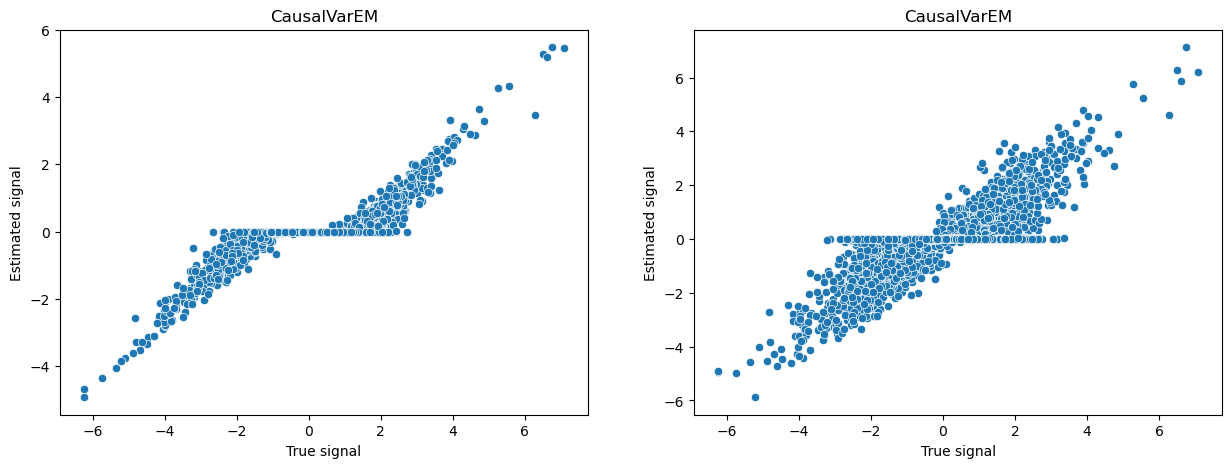

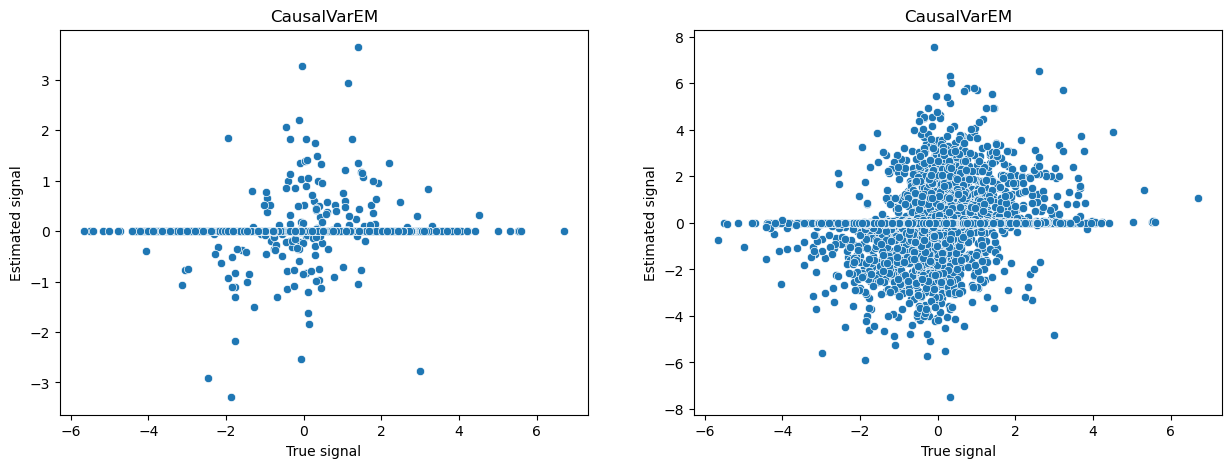

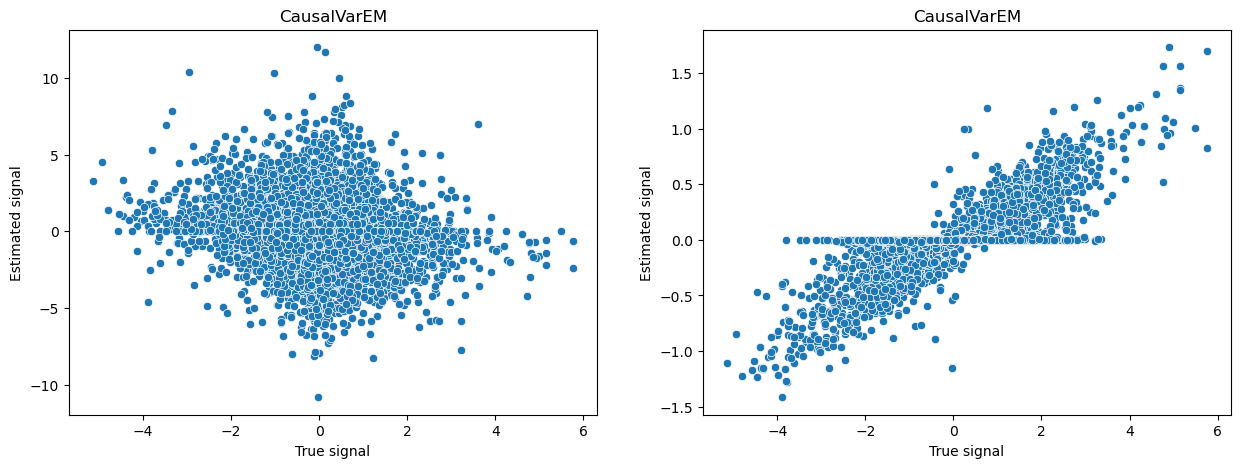

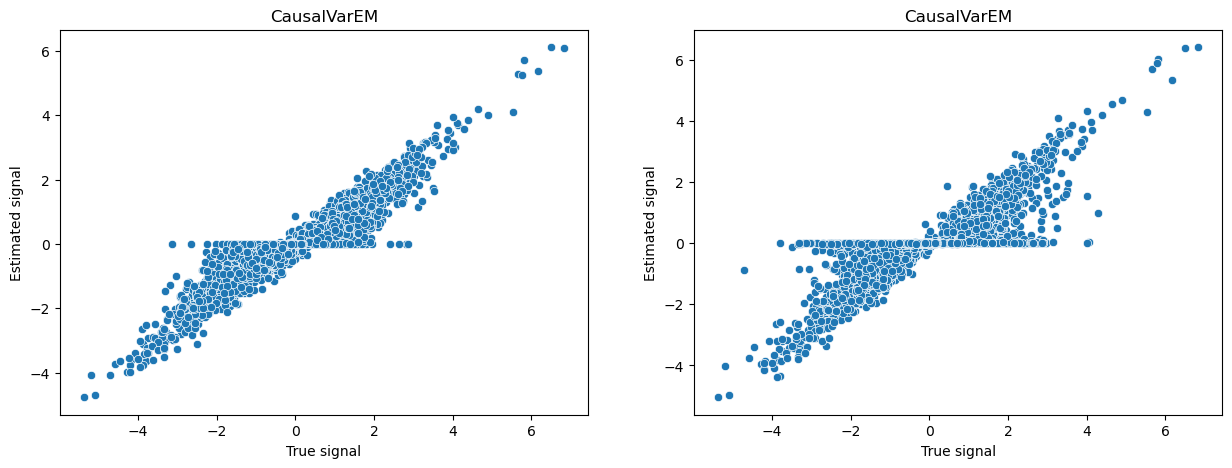

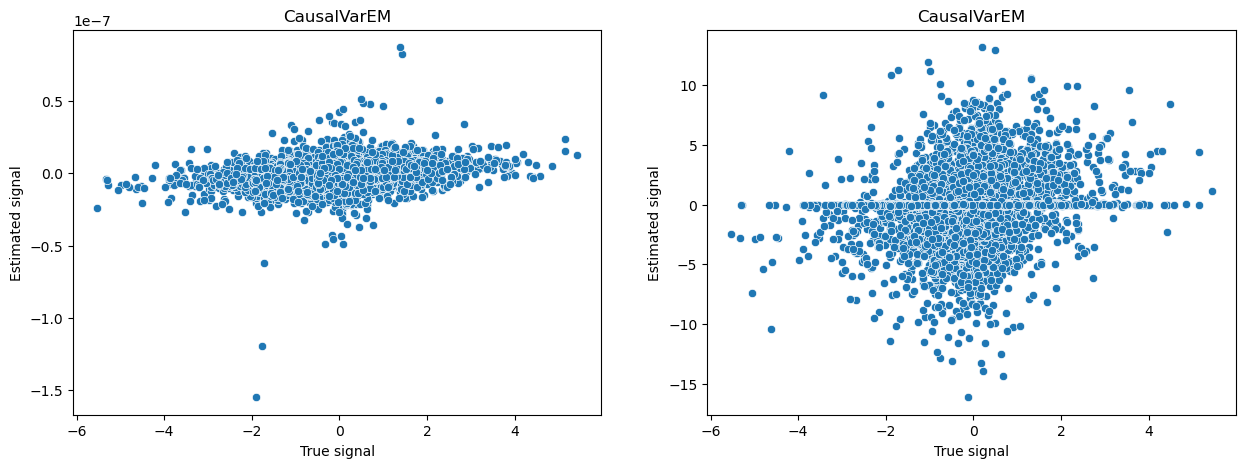

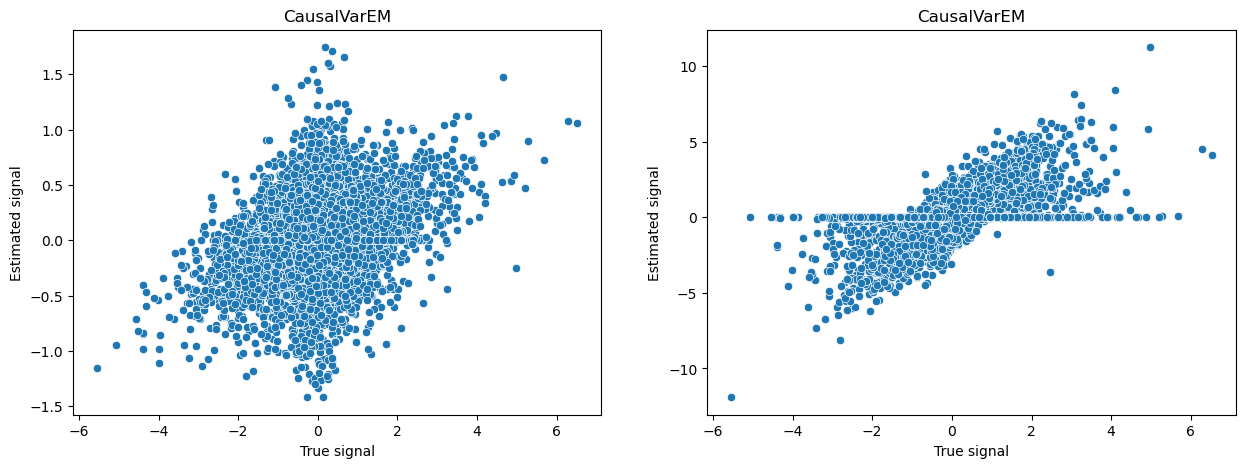

In [13]:
# plot 
for i in range(J):
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    sns.scatterplot(x = data.signals[:,i], y = source_est.Signals[:,i], ax = ax[0])
    ax[0].title.set_text('CausalVarEM')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_Causal[:,i], ax = ax[1])
    ax[1].title.set_text('CausalVarEM')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    plt.show()

NameError: name 'results' is not defined

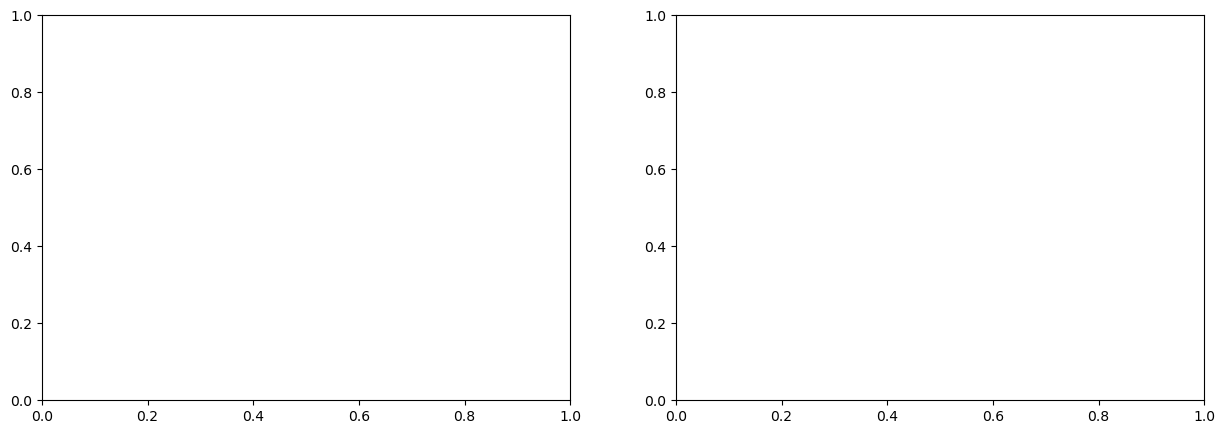

In [14]:
# plot scores
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.score_var, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.histplot(results.score_causal, ax = ax[1])
ax[1].title.set_text('CausalVarEM')


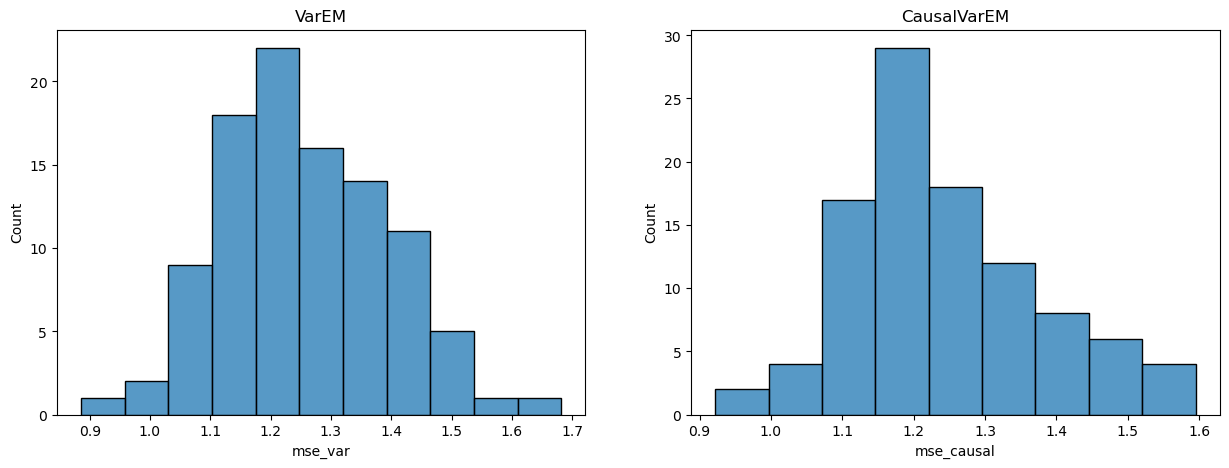

In [24]:
# plot mse
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.mse_var, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.histplot(results.mse_causal, ax = ax[1])
ax[1].title.set_text('CausalVarEM')


(-10.0, 10.0)

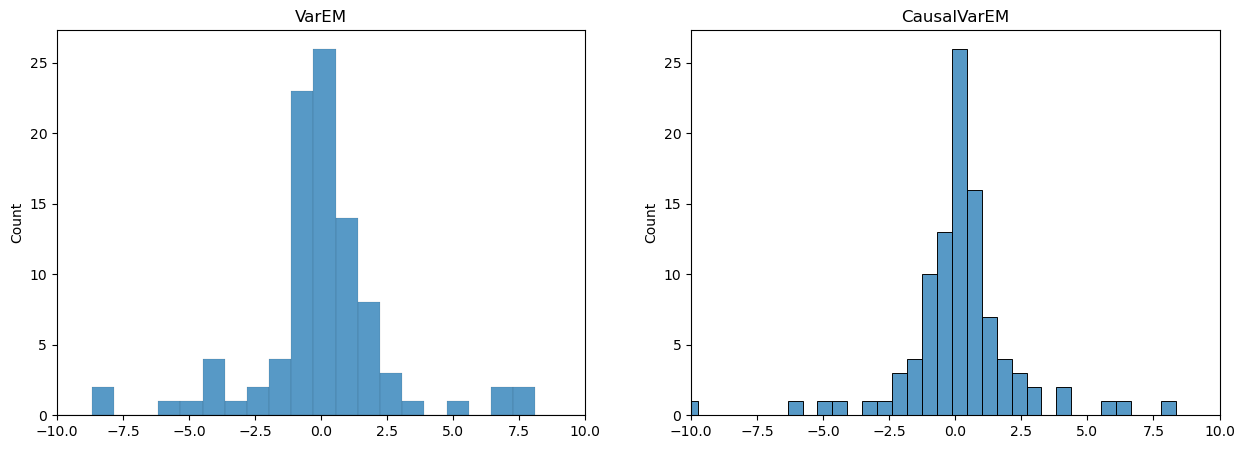

In [26]:
# plot difference between true and estimated treatment effect exclude outliers +-10
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.treatment_true - results.treatment_var_first_column, ax = ax[0])
ax[0].title.set_text('VarEM')
ax[0].set_xlim(-10,10)
sns.histplot(results.treatment_true - results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
ax[1].set_xlim(-10,10)


